In [42]:
from networkx import radius
import pandas as pd
import numpy as np

class Node:
    """x, y, function, input0x input0y, input1x, input1y, input2x, input2y, input3x, input3y"""
    def __init__(self, x, y, function, input0x=None, input0y=None, input1x=None, input1y=None, input2x=None, input2y=None, input3x=None, input3y=None):
        self.x = x
        self.y = y
        self.function = function
        self.input0x = input0x
        self.input0y = input0y
        self.input1x = input1x
        self.input1y = input1y
        self.input2x = input2x
        self.input2y = input2y
        self.input3x = input3x
        self.input3y = input3y

    def lut4_to_logic(self) -> str:
        """
        Convert a 16-bit LUT mask into a lambda expression string
        using AND/OR/NOT logic over inputs in3..in0.
        """
        terms = []

        for i in range(16):
            if (self.function >> i) & 1:  # if this input pattern produces a 1
                # Extract bits for in3..in0
                in0 = (i >> 0) & 1
                in1 = (i >> 1) & 1
                in2 = (i >> 2) & 1
                in3 = (i >> 3) & 1

                # Build minterm
                parts = []
                for name, val in zip(["in3", "in2", "in1", "in0"], [in3, in2, in1, in0]):
                    parts.append(name if val else f"(not {name})")

                terms.append("(" + " and ".join(parts) + ")")

        if not terms:
            body = "0"
        elif len(terms) == 1:
            body = terms[0]
        else:
            body = "(\n    " + " or\n    ".join(terms) + "\n)"

        return f"lambda in3, in2, in1, in0: {body}"

        
    def lut4(self):
        """Return a lambda implementing a 4-input LUT function for a 16-bit truth table."""
        return lambda in3, in2, in1, in0: (self.function >> ((in3 << 3) | (in2 << 2) | (in1 << 1) | in0)) & 1

    def __str__(self):
        op = self.lut4_to_logic()
        return f"Node(({self.x}, {self.y}), function={op}, inputs=({self.input0x},{self.input0y}),({self.input1x},{self.input1y}),({self.input2x},{self.input2y}),({self.input3x},{self.input3y}))"
    
    def twos_complement(val, bits):
        """
        Computes the two's complement of a positive integer 'val' 
        for a given number of 'bits'.
        """
        # Calculate the one's complement by inverting all bits
        ones_comp = ~val & ((1 << bits) - 1) 
        # Add 1 to get the two's complement
        twos_comp = ones_comp + 1
        return twos_comp
    
    def to_verilog(self):
        def input_str(x, y):
            if x is None or y is None:
                return "1'b0"
            elif x == 0:
                return f"in{y%10}"
            else:
                return f"x{x}_y{y}"
        return f"""
(* keep, dont_touch *)
(* LOC = "X{self.x}/Y{self.y}" *)
SB_LUT4 #(
    .LUT_INIT(16'b{Node.twos_complement(self.function, 16):016b})
) lut_{self.x}_{self.y} (
    .O(x{self.x}_y{self.y}),
    .I0({input_str(self.input0x, self.input0y)}),
    .I1({input_str(self.input1x, self.input1y)}),
    .I2({input_str(self.input2x, self.input2y)}),
    .I3({input_str(self.input3x, self.input3y)})
);"""

    def mutate(self, lut_rate=0.01, input_rate=0.1, x_radius=2, y_radius=5, none_weight=0.25):
        # Mutate the function with a certain probability
        flip_mask = 0
        for i in range(16):
            if np.random.rand() < lut_rate:
                flip_mask |= (1 << i)
        self.function ^= flip_mask
        
        # def mutate_input(x, y):
        #     if np.random.rand() < input_rate:
        #         if np.random.rand() < none_weight:
        #             return None, None
        #         x_offset = np.random.randint(-x_radius, x_radius + 1)
        #         y_offset = np.random.randint(-y_radius, y_radius + 1)
        #         return max(x + x_offset, 0), max(min(y + y_offset, 49), 0)
        #     return x, y
        
        # self.input0x, self.input0y = mutate_input(self.input0x, self.input0y)
        # self.input1x, self.input1y = mutate_input(self.input1x, self.input1y)
        # self.input2x, self.input2y = mutate_input(self.input2x, self.input2y)
        # self.input3x, self.input3y = mutate_input(self.input3x, self.input3y)

    def __repr__(self):
        return self.__str__()

def decode_nodes(arr):
    nodes = []
    # Loop over every 9 elements (each node has 9 values: 1 function + 8 input coordinates)
    for i in range(0, len(arr), 9):
        if i + 8 < len(arr):  # Ensure we have all 9 values
            function = arr[i]
            
            # Extract input coordinates (4 pairs: x,y for each input)
            input0x, input0y = arr[i+1], arr[i+2]
            input1x, input1y = arr[i+3], arr[i+4]
            input2x, input2y = arr[i+5], arr[i+6]
            input3x, input3y = arr[i+7], arr[i+8]
            
            node_index = i // 9
            total_nodes = len(arr) // 9
            # Calculate x, y coordinates based on grid arrangement
            grid_size = int(np.sqrt(total_nodes))
            x = node_index % grid_size
            y = node_index // grid_size
            
            # Create node object
            node = Node(x, y, function, input0x, input0y, input1x, input1y, 
                        input2x, input2y, input3x, input3y)
            
            nodes.append(node)
    
    return nodes

def generate_random_nodes(num_nodes=100):
    """Generate a random array representing nodes for decode_nodes function."""
        
    arr = []
    grid_size = int(np.sqrt(num_nodes))
    
    def generate_random_coords(x, y, x_radius=2, y_radius=5, none_weight=0.25):
        # Generate random coordinates within a given length
        if np.random.rand() < none_weight:
            return None, None
        x_offset = np.random.randint(-x_radius, 0)  # Change 0 to x_radius to allow cycles
        y_offset = np.random.randint(-y_radius, y_radius + 1)
        return max(x + x_offset, 0), max(min(y + y_offset, grid_size - 1), 0)

    for i in range(num_nodes):
        # Random 16-bit function
        function = np.random.randint(0, 2**16)
        
        # Calculate node position in grid
        x = i % grid_size
        y = i // grid_size
        
        if x == 9:
            input0x, input0y = generate_random_coords(x-1, y)
            input1x, input1y = generate_random_coords(x-1, y)
            # input2x, input2y = generate_random_coords(x-1, y)
            # input3x, input3y = generate_random_coords(x-1, y)
        else:
            # Random input coordinates for other nodes
            input0x, input0y = generate_random_coords(x-1, y)
            input1x, input1y = generate_random_coords(x-1, y)
            input2x, input2y = generate_random_coords(x-1, y)
            input3x, input3y = generate_random_coords(x-1, y)
        
        # Add all 9 values for this node (1 function + 8 input coordinates)
        arr.extend([function, input0x, input0y, input1x, input1y, input2x, input2y, input3x, input3y])
        
    return np.array(arr)

arr = generate_random_nodes(2500)
# print(arr)
nodes = decode_nodes(arr)
node = nodes[5]
node

Node((5, 0), function=lambda in3, in2, in1, in0: (
    ((not in3) and (not in2) and (not in1) and (not in0)) or
    ((not in3) and (not in2) and in1 and in0) or
    ((not in3) and in2 and (not in1) and (not in0)) or
    ((not in3) and in2 and (not in1) and in0) or
    ((not in3) and in2 and in1 and (not in0)) or
    (in3 and (not in2) and (not in1) and in0) or
    (in3 and (not in2) and in1 and (not in0)) or
    (in3 and in2 and (not in1) and in0)
), inputs=(2,0),(2,0),(None,None),(3,3))

In [43]:
node.lut4()(0, 0, 1, 0)

0

In [44]:
print(node.to_verilog())


(* keep, dont_touch *)
(* LOC = "X5/Y0" *)
SB_LUT4 #(
    .LUT_INIT(16'b1101100110000111)
) lut_5_0 (
    .O(x5_y0),
    .I0(x2_y0),
    .I1(x2_y0),
    .I2(1'b0),
    .I3(x3_y3)
);


In [45]:
import networkx as nx
import matplotlib.pyplot as plt

class Individual:
    def __init__(self, population=None, num_nodes=100):
        if population is None:
            population = generate_random_nodes(num_nodes)
        self.population = population
        self.nodes = decode_nodes(population)

    def make_verilog(self, module_name="cgp_module"):
        outputs = []
        wires = []

        for node in self.nodes:
            if node.x == int(np.sqrt(len(self.nodes))) - 1:
                outputs.append(f"x{node.x}_y{node.y}")
            else:
                wires.append(f"x{node.x}_y{node.y}")
                
        inputs = [f"in{i}" for i in range(10)]
        outputs = [f"out{i}" for i in range(10)]
        
        verilog_lines = []
        verilog_lines.append(f"module {module_name} (")
        
        # Declare inputs and outputs
        verilog_lines.append("    (* keep *) input " + ", ".join(inputs) + ",")
        verilog_lines.append("    (* keep *) output " + ", ".join(outputs) + ");\n")
        verilog_lines.append("    (* keep *) wire " + ", ".join(wires) + ";\n")
        
        # Instantiate each node
        for node in nodes:
            verilog_lines.append(node.to_verilog())
        
        verilog_lines.append("\nendmodule")
        
        return "\n".join(verilog_lines)
    
    def mutate(self, lut_rate=0.01, input_rate=0.1, x_radius=2, y_radius=5, none_weight=0.25):
        [n.mutate(lut_rate, input_rate, x_radius, y_radius, none_weight) for n in self.nodes]
        
    def crossover(self, other: Individual, crossover_rate=0.7):
        """Perform crossover between this individual and another individual."""
        if np.random.rand() < crossover_rate:
            # Single-point crossover
            point = np.random.randint(1, len(self.population) - 1)
            new_population = np.concatenate((self.population[:point], other.population[point:]))
            return Individual(population=new_population)
        else:
            # No crossover, return a copy of this individual
            return Individual(population=self.population.copy())
        
    def display(self):
        G = nx.DiGraph()
        
        for node in self.nodes:
            G.add_node((node.x, node.y))
            for input_coords in [(node.input0x, node.input0y), (node.input1x, node.input1y), (node.input2x, node.input2y), (node.input3x, node.input3y)]:
                if input_coords != (None, None):
                    G.add_edge(input_coords, (node.x, node.y))

        # Use node coordinates as positions
        pos = {(node.x, node.y): (node.x, node.y) for node in self.nodes}
        nx.draw(G, pos, with_labels=True, node_size=250, node_color='lightblue')
        plt.show()

    def __str__(self):
        return f"Individual(population={self.population}, nodes={self.nodes})"
    
ind = Individual(num_nodes=100)
with open('individual.txt', 'w') as f:
    f.write(str(ind))

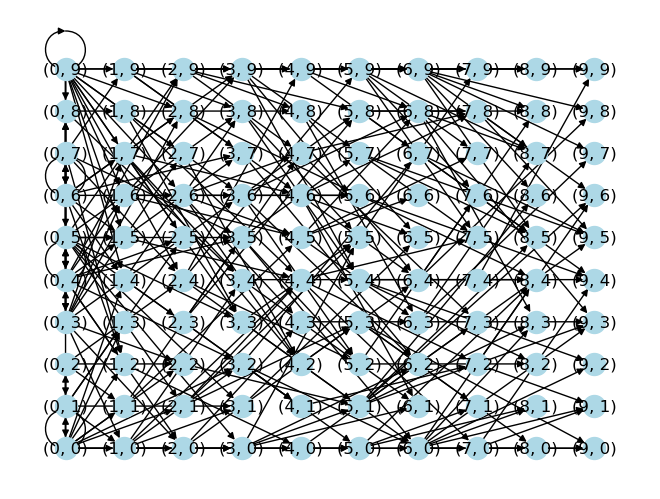

In [46]:
ind.display()